In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from sqlalchemy import create_engine
from config import (user, password, host, port, database)

In [2]:
engine = create_engine(f'postgresql://{user}:{password}@{host}:{port}/{database}')
conn = engine.connect()

In [3]:
employees_df = pd.read_sql('select * from employees;', conn)
employees_df.sort_values(by='hire_date', ascending=True).head()

,emp_no,emp_title_id,birth_date,first_name,last_name,sex,hire_date
176177,110303,m0001,1956-06-08,Krassimir,Wegerle,F,1985-01-01
59074,110022,m0001,1956-09-12,Margareta,Markovitch,M,1985-01-01
117269,110183,m0001,1953-06-24,Shirish,Ossenbruggen,F,1985-01-01
44344,110725,m0001,1961-03-14,Peternela,Onuegbe,F,1985-01-01
61952,111035,m0001,1962-02-24,Przemyslawa,Kaelbling,M,1985-01-01


In [4]:
departments_df = pd.read_sql('select * from departments;', conn)
departments_df.head()

,dept_no,dept_name
0,d001,Marketing
1,d002,Finance
2,d003,Human Resources
3,d004,Production
4,d005,Development


In [5]:
dept_managers_df = pd.read_sql('select * from dept_manager;', conn)
dept_managers_df.head()

,dept_no,emp_no
0,d001,110022
1,d001,110039
2,d002,110085
3,d002,110114
4,d003,110183


In [6]:
dept_emp_df = pd.read_sql('select * from dept_emp;', conn)
dept_emp_df.head()

,emp_no,dept_no
0,10001,d005
1,10002,d007
2,10003,d004
3,10004,d004
4,10005,d003


In [7]:
salaries_df = pd.read_sql('select * from salaries;', conn)
salaries_df.head()

,emp_no,salary
0,10001,60117
1,10002,65828
2,10003,40006
3,10004,40054
4,10005,78228


In [8]:
titles_df = pd.read_sql('select * from titles;', conn)
titles_df.head()

,title_id,title
0,s0001,Staff
1,s0002,Senior Staff
2,e0001,Assistant Engineer
3,e0002,Engineer
4,e0003,Senior Engineer


In [9]:
def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier

def round_up(n, decimals=0): 
    multiplier = 10 ** decimals 
    return math.ceil(n * multiplier) / multiplier

In [10]:
# get max and mins of salaries, round up and down to nearest to 10,000, respectively
salary_min = int(round_down(salaries_df['salary'].min(), -4))
salary_max = int(round_up(salaries_df['salary'].max(), -4))

# find range of salaries
salary_range = salary_max - salary_min

# split range into 5 even groups using an increment
salary_bin_increments = (salary_range / 5)

# create all types bins
salary_bins = [int(salary_min),
               int(salary_min + salary_bin_increments),
               int(salary_min + (salary_bin_increments * 2)),
               int(salary_min + (salary_bin_increments * 3)),
               int(salary_min + (salary_bin_increments * 4)),
               int(salary_max)]

# create bin labels
salary_bin_labels = [f'${salary_min}-{int(salary_min + salary_bin_increments)}',
                     f'${int(salary_min + salary_bin_increments + 1)}-{int(salary_min + (salary_bin_increments*2))}',
                     f'${int(salary_min + (salary_bin_increments*2) + 1)}-{int(salary_min + (salary_bin_increments*3))}',
                     f'${int(salary_min + (salary_bin_increments*3) + 1)}-{int(salary_min + (salary_bin_increments*4))}',
                     f'${int(salary_min + (salary_bin_increments*4) + 1)}-{salary_max}']

# name bin and separate rows into bins
salaries_df['Groups by Salary Range'] = pd.cut(salaries_df['salary'],salary_bins, labels=salary_bin_labels, include_lowest=True)
salaries_df

# create group by bin
salaries_grouped_df = salaries_df.groupby('Groups by Salary Range')
salaries_grouped_df.count()

# calculate counts by category
salary_range_count = salaries_grouped_df['emp_no'].count()

# create new grouped df
salary_groups_df = pd.DataFrame({'Count of Employees': salary_range_count})

salary_groups_df.reset_index(inplace=True)

salary_groups_df

,Groups by Salary Range,Count of Employees
0,$40000-58000,206067
1,$58001-76000,68385
2,$76001-94000,22401
3,$94001-112000,3016
4,$112001-130000,155


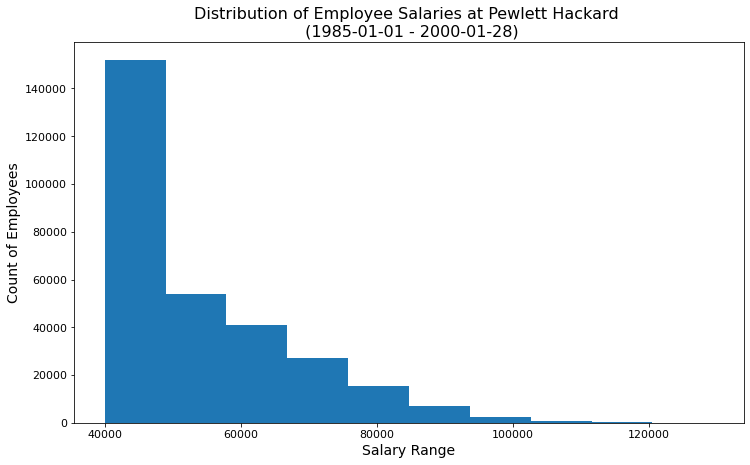

In [13]:
hire_date_min = employees_df['hire_date'].min()
hire_date_max = employees_df['hire_date'].max()

x = salaries_df['salary']

plt.figure(figsize= (12,7))
plt.hist(x, density=False, bins=10)
plt.tick_params(axis='both', which='major', labelsize=11)
plt.xlabel('Salary Range', size=14)
plt.ylabel('Count of Employees', size=14)
plt.title(f'Distribution of Employee Salaries at Pewlett Hackard \n ({hire_date_min} - {hire_date_max})', size=16)
plt.show()

In [20]:
merge_df = employees_df.merge(salaries_df, how='inner', on=['emp_no'])
merge_df = merge_df.merge(dept_emp_df, how='inner', on=['emp_no'])
merge_df = merge_df.merge(departments_df, how='left', on=['dept_no'])
final_df = merge_df[['emp_no', 'salary', 'dept_name']]
final_df

,emp_no,salary,dept_name
0,473302,40000,Finance
1,475053,53422,Production
2,57444,48973,Production
3,421786,40000,Human Resources
4,282238,40000,Quality Management
...,...,...,...
331598,255832,75355,Production
331599,76671,61886,Sales
331600,264920,62772,Finance
331601,264920,62772,Sales


In [24]:
grouped_dept_df = final_df.groupby('dept_name')
grouped_dept_df.count()

# calculate avg by department
avg_salary_by_dept = grouped_dept_df['salary'].mean()

# create new grouped df
grouped_dept_df = pd.DataFrame({'avg_salary': avg_salary_by_dept})

grouped_dept_df.reset_index(inplace=True)

grouped_dept_df

,dept_name,avg_salary
0,Customer Service,47998.670441
1,Development,48697.334663
2,Finance,59533.516546
3,Human Resources,44678.646801
4,Marketing,61095.897383
5,Production,48760.450827
6,Quality Management,46456.005717
7,Research,48850.189719
8,Sales,69832.127151
